In [ ]:
%matplotlib inline

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time

In [2]:
%cd ../
import DTW
import TSM_Import

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment


# Import Data and Hyperparameter

In [3]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

## Set Hop Length

In [59]:
hop_length = 512

# Segmental DTW

## Feature Extraction

In [42]:
def getChromaFeatures(audio, sr=22050):
  chroma = lb.feature.chroma_stft(y=audio, norm=2, hop_length=hop_length)
  return chroma

## Segmental DTW

In [43]:
def getCostMatrices(queries, ref):
  cost_matrices = []
  for query_chroma in queries:
    cost_matrices.append(sspat.distance.cdist(query_chroma.T, ref.T, metric='cosine'))
  return cost_matrices


In [44]:
def getAccumCostMatrix(cost_matrix):
  steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
  weights = [2,1,1]
  D = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=False)
  return D

In [45]:
def generateSegmentCostMatrix(costMatrices):
  frame_cost_matrix = []
  for D in costMatrices:
    cost = D[-1,:]
    frame_cost_matrix.append(cost)
  return frame_cost_matrix

In [46]:
def segmental_DTW(segmentCostMatrix, segment_lengths):
  steps = [[0,1]]
  weights = [0]
  D, path = DTW.globalDTW(segmentCostMatrix, steps, weights, segment_lengths)

  return D, path

In [47]:
def getPathEnds(global_path, C0):
  endpoints = []
  for idx in range(1,len(global_path)):
    if global_path[idx][0]!=global_path[idx-1][0]:
      endpoints.append(global_path[idx])
  endpoints.insert(0,(0,np.argmin(C0)))
  return endpoints


## TSM

In [48]:
def extrapolateTimeStretchFunction(local_paths, N):
  new_stretch = []
  k = 0
  slope = 1
  new_time = 0
  counter = 0
  for i in range(0,N):
    if k<len(local_paths) and i >= local_paths[k][0][1]*hop_length and i <= local_paths[k][-1][1]*hop_length:
      path = local_paths[k]
      #if i == path[0][1]*hop_length:
        #print(i,new_time)
      if i == path[-1][1]*hop_length:
        #print(i, new_time)    
        k+=1
        slope=1
        counter = 0
      elif i == path[counter][1]*hop_length:
        slope = (path[counter+1][0]-path[counter][0])/(path[counter+1][1]-path[counter][1])
        counter+=1
    else:
      slope=1
    new_time+=slope
    new_stretch.append(int(new_time))
  return new_stretch
def getInverseTimeFunction(time_function):
  inverse_function = []
  counter = 0
  for i in range(time_function[-1]+1):
    while time_function[counter]<i:
      counter+=1
    inverse_function.append(counter)
  return inverse_function

## Process Queries

In [49]:
def writeToFile(tf, segment_predict, solo_name, ref_name, hypdir, time_taken):
    if hypdir != None:
        experiment = "experiments/{}".format(hypdir)
        if not os.path.exists(experiment):
            os.mkdir(experiment)
        fname = "experiments/{}/{}-{}.hyp".format(hypdir,solo_name,ref_name)
        with open (fname, 'wb') as f:
            pkl.dump((solo_name, ref_name, tf, segment_predict, time_taken),f)

In [50]:
def tf_preprocessing(local_paths):
    ls = []
    for seg in local_paths:
        new_seg = []
        for pair in seg:
            new_seg.append(np.array([pair[0],pair[1]]))
        ls.append(np.array(new_seg))
    return ls
def seg_time_function(wp):
    start_time  = time.time()
    wp = wp*hop_length
    output = np.zeros((wp[-1,1]-wp[0,1])+1)
    x_b = wp[0,1]
    for pair_index in range(len(wp)-1):
        y_0 = wp[pair_index,0]
        y_1 = wp[pair_index+1,0]
        x_0 = wp[pair_index,1]
        x_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0-x_b:x_1-x_b] = array
    output[-1] = wp[-1,0]

    return output
def group_time_function(wp,ref_audio_len):
    wp = tf_preprocessing(wp)
    start_time = time.time()

    output = np.zeros(ref_audio_len)
    

    current_start = 0
    for index, seg_path in enumerate(wp):

        pre_padd_end = seg_path[0][1] * hop_length

        output[current_start:pre_padd_end]=(np.arange(pre_padd_end-current_start)+1)+output[current_start-1]

        current_start = pre_padd_end
        tf = seg_time_function(seg_path)
        if index > 0:
            start_point = max(0,wp[index-1][-1][1]-wp[index][0][1])*hop_length
            end_point = min(len(output)-current_start,len(tf))

            tf = tf[start_point:end_point]

        if len(tf)>=2:
            output[current_start:current_start+len(tf)] = tf+tf[1]+output[current_start-1]
        elif len(tf)==1:
            output[current_start:current_start+len(tf)] = tf+output[current_start-1]
        current_start = current_start+len(tf)

    output[current_start:]=np.arange(ref_audio_len-current_start)+output[current_start-1]
    return output

In [51]:
def processQuery(solo_name, ref_name, visualize=False, hypdir = None, sr=22050):
  print("Processing solo {}, Accompaniment {}".format(solo_name, ref_name))
  warnings.filterwarnings("ignore", category=DeprecationWarning)
  start_time = time.time()
  outfile = 'experiments/{}/{}-{}.hyp'.format(hypdir, solo_name, ref_name)
  if os.path.exists(outfile) and visualize == False:
    print("Skipped: {}".format(outfile))
    return None

  solo_segments = audioFiles[solo_name]
  ref_audio = audioFiles[ref_name]

  # Calculate L2-Normalized Chromas
  solo_chromas = []
  segment_lengths = []
  ref_chroma = getChromaFeatures(ref_audio)
  for i in solo_segments:
    solo_chromas.append(getChromaFeatures(i))
    segment_lengths.append(solo_chromas[-1].shape[1])

  # Frame-Level DTW
  frame_costs = []
  cost_matrices = getCostMatrices(solo_chromas, ref_chroma)
  

  accum_costs = []
  for C in cost_matrices:
    D = getAccumCostMatrix(C)
    accum_costs.append(D)
    
  #plt.imshow(cost_matrices[-1], aspect='auto')
  #lbd.specshow(cost_matrices[-1], x_axis='frames', y_axis='frames')
  
  # Segment-Level DTW
  segment_cost = np.array(generateSegmentCostMatrix(accum_costs))
  D, path = segmental_DTW(segment_cost, segment_lengths)
  pathEnds = getPathEnds(path[::-1],segment_cost[0])
  
  if visualize:
      lbd.specshow(D, x_axis='frames', y_axis='frames')
      x = [i[0] for i in path]
      y = [i[1] for i in path]
      plt.plot(y, x, label='Optimal path', color='y')
      keys = queryInfo[solo_name.split('_')[0]]
      samples = []
      for idx,key in enumerate(keys):
          i = key.split(',')[1][:-1]
          plot_time = timeData[ref_name][i]
          sample = np.round(plot_time*sr/hop_length)
          plt.plot(int(sample), idx, marker=".", markersize=16)


  # Local Backtraces
  local_paths = []
  segment_predict = []
  for idx, C in enumerate(cost_matrices):
    local_path = list(DTW.local_backtrace(accum_costs[idx],C,pathEnds[idx][1]))[::-1]
    local_paths.append(local_path)
    segment_predict.append((local_path[0][1],pathEnds[idx][1]))
#  print(segment_predict)
#     if idx==1:
#       lbd.specshow(accum_costs[idx], x_axis='frames', y_axis='frames')
#       x = [i[0] for i in local_path]
#       y = [i[1] for i in local_path]
#       plt.plot(y,x, label='Optimal path', color='y')
#       debug_path = local_path

    
  
  # TSM
  print(time.time()-start_time)
  time_function = group_time_function(local_paths, len(ref_audio))
  #time_function = extrapolateTimeStretchFunction(local_paths, len(ref_audio))
  #time_function = extrapolateTimeStretchFunction(local_paths)
  #time_function = np.array(analysis2synthesis(local_paths, len(ref_audio)))
  time_taken = time.time()-start_time
  print("Took {} seconds".format(time_taken))
  writeToFile(time_function, segment_predict, solo_name, ref_name, hypdir, time_taken)
  return time_function, local_paths, segment_cost,D, segment_predict

Processing solo p2s_perf10, Accompaniment p2f_perf1
0.41463184356689453
Took 0.4526998996734619 seconds


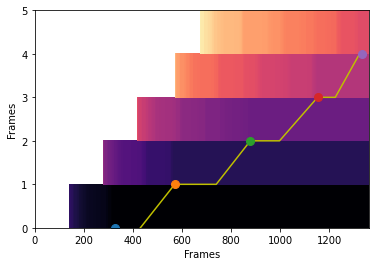

In [52]:
solo_name, ref_name ='p2s_perf10', 'p2f_perf1'
time_function, local_paths,sc,D, sp  = processQuery(solo_name, ref_name, visualize=True, hypdir="debug4")

In [53]:
for i in local_paths:
    print(i[0][1]*hop_length,i[-1][1]*hop_length)

360448 1318912
1343488 2338816
2592768 3600384
3534848 4722688
4722688 5423104


In [54]:
len(time_function),len(audioFiles[ref_name])

(5585464, 5585464)

In [55]:
pieceName = solo_name.split('_')[0]
gt_segments = queryInfo[pieceName]
sr=22050
for beats in gt_segments:
    beat1 = beats.split(',')[0][1:]
    beat2 = beats.split(',')[1][:-1]
    sample1 = (timeData[ref_name][beat1]*sr)
    sample2 = (timeData[ref_name][beat2]*sr)
    print(sample1,sample2)

344814.9999987 1345851.3333310501
1345851.3333310501 2338564.6666662
2595318.3333304496 3600637.66666695
3600637.66666695 4727908.0000026
4727908.0000026 5454163.0000053


In [56]:
for t1, t2 in sp:
    print(t1*hop_length, t2*hop_length)

360448 1318912
1343488 2338816
2592768 3600384
3534848 4722688
4722688 5423104


In [ ]:
a1 = lb.feature.chroma_cens(y=audioFiles['p1s_perf12'][-1], sr=22050)
a2 = lb.feature.chroma_cens(y=audioFiles['p1f_perf23'], sr=22050)
print(a1.shape)
steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
weights = [2,1,1]
D,wp=lb.sequence.dtw(a1,a2, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
print(wp)

In [58]:
# Process all queries
multiprocess = False
hypdir = "exp_hop_4096"
solo = {}
accompaniment = {}
for fileId in fileIds:
    pieceNum = fileId.split("_")[0]
    if 's' in fileId:
        if not pieceNum in solo.keys():
            solo[pieceNum] = [fileId]
        else:
            solo[pieceNum].append(fileId)
    if 'f' in fileId:
        if not pieceNum in accompaniment.keys():
            accompaniment[pieceNum] = [fileId]
        else:
            accompaniment[pieceNum].append(fileId)
inputs = []
for piece in solo.keys():
    soloPieces = solo[piece]
    refPieces = accompaniment[piece[:-1]+'f']
    for i in soloPieces:
        for j in refPieces:
            inputs.append([i,j,False, hypdir])

if multiprocess: 
    n_cores = multiprocessing.cpu_count()-1
    pool = multiprocessing.Pool(processes=n_cores)
    outputs = list(pool.starmap(processQuery, inputs))
else:
    for i in inputs:
        processQuery(i[0], i[1], i[2], i[3])
        #print(len(tf),len(audioFiles[i[1]]))

Processing solo p1s_perf12, Accompaniment p1f_perf16
Skipped: experiments/exp_hop_4096/p1s_perf12-p1f_perf16.hyp
Processing solo p1s_perf12, Accompaniment p1f_perf2
0.2848496437072754
Took 0.3117504119873047 seconds
Processing solo p1s_perf12, Accompaniment p1f_perf23
0.2503039836883545
Took 0.27537965774536133 seconds
Processing solo p1s_perf12, Accompaniment p1f_perf24
0.2565150260925293
Took 0.2823622226715088 seconds
Processing solo p1s_perf12, Accompaniment p1f_perf6
0.2522099018096924
Took 0.2776463031768799 seconds
Processing solo p1s_perf2, Accompaniment p1f_perf16
0.24412250518798828
Took 0.27281999588012695 seconds
Processing solo p1s_perf2, Accompaniment p1f_perf2
0.2668764591217041
Took 0.30158376693725586 seconds
Processing solo p1s_perf2, Accompaniment p1f_perf23
0.26111793518066406
Took 0.2866206169128418 seconds
Processing solo p1s_perf2, Accompaniment p1f_perf24
0.24211382865905762
Took 0.2697875499725342 seconds
Processing solo p1s_perf2, Accompaniment p1f_perf6
0.238

0.3205685615539551
Took 0.35956668853759766 seconds
Processing solo p4s_perf2, Accompaniment p4f_perf2
0.3368251323699951
Took 0.37120985984802246 seconds
Processing solo p4s_perf8, Accompaniment p4f_perf13
0.2787802219390869
Took 0.3167848587036133 seconds
Processing solo p4s_perf8, Accompaniment p4f_perf16
0.2687497138977051
Took 0.3062295913696289 seconds
Processing solo p4s_perf8, Accompaniment p4f_perf2
0.2955210208892822
Took 0.3394200801849365 seconds
Processing solo p4s_perf9, Accompaniment p4f_perf13
0.3245508670806885
Took 0.36338067054748535 seconds
Processing solo p4s_perf9, Accompaniment p4f_perf16
0.312960147857666
Took 0.34981846809387207 seconds
Processing solo p4s_perf9, Accompaniment p4f_perf2
0.33307886123657227
Took 0.3676741123199463 seconds


In [ ]:
ref_audio = audioFiles['p3f_perf24']
ipd.Audio(ref_audio, rate = 22050)

In [ ]:
time_function = getInverseTimeFunction(time_function)

In [ ]:
new_audio = TSM_Import.phase_vocoder(ref_audio,time_function)